## Predict sentiment score of cryptocurrencies c with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd
from fedot_ind.tools.loader import DataLoader
from examples.example_utils import init_input_data

D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [2]:
from cases.utils import ts_regression_setup
dataset_name = 'EthereumSentiment'
OperationTypesRepository, tuning_params, data_path, experiment_setup, model_dict = ts_regression_setup()
experiment_setup['output_folder'] = f'./{dataset_name}/results_of_experiment'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [3]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-01-18 13:37:08,808 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/EthereumSentiment


In [4]:
input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
val_data = init_input_data(test_data[0], test_data[1], task=tuning_params['task'])

Lets check our data.

In [5]:
input_data.features.shape

(249, 2, 24)

Lets visualise our predictors.

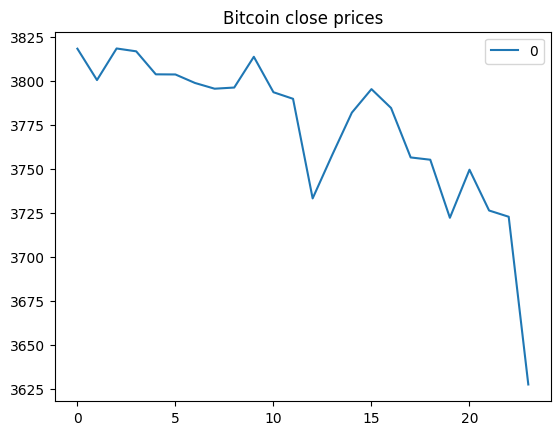

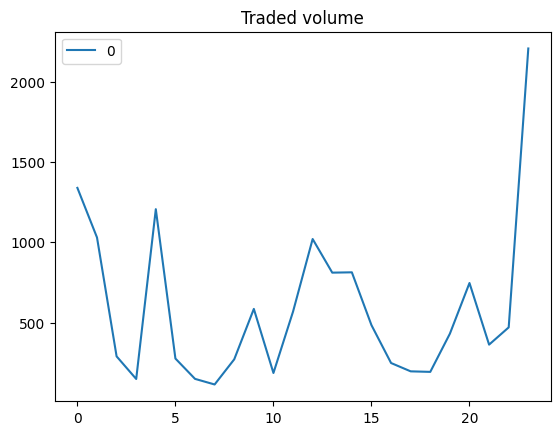

In [6]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='Bitcoin close prices')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='Traded volume')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [7]:
from cases.utils import evaluate_industrial_model
metric_dict = evaluate_industrial_model(input_data=input_data,
                                        val_data=val_data,
                                        model_dict=model_dict)

Current_model - regression_with_statistical_features


100%|██████████| 107/107 [00:00<00:00, 1094.75it/s]


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [8]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline.sort_values(by='root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_with_statistical_features,0.280423,0.051787,0.227568,0.173129,0.130617,0.287686,0.743335,0.187089


In [9]:
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Could it be done better? Tuning approach

In [10]:
from cases.utils import finetune
metric_dict = finetune(tuning_params, model_dict, train_data, test_data, val_data, input_data)

Current_model - regression_with_statistical_features
2024-01-18 13:37:22,458 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-01-18 13:37:22,460 - DataSourceSplitter - Hold out validation is applied.
2024-01-18 13:37:22,462 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


100%|██████████| 50/50 [00:00<00:00, 1165.90it/s]


2024-01-18 13:37:22,969 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 0} 
Initial metric: [0.243]
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]2024-01-18 13:37:22,975 - build_posterior_wrapper took 0.001994 seconds
2024-01-18 13:37:22,975 - TPE using 0 trials


  0%|          | 0/199 [00:00<?, ?it/s]

 66%|######6   | 132/199 [00:00<00:00, 980.39it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 835.57it/s]


 33%|███▎      | 1/3 [00:00<00:00,  2.02trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:23,471 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:23,472 - TPE using 1/1 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 66%|######6   | 132/199 [00:00<00:00, 959.07it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 1165.90it/s]


 67%|██████▋   | 2/3 [00:01<00:00,  1.81trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:24,062 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:24,063 - TPE using 2/2 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 833.91it/s]

 90%|######### | 180/199 [00:00<00:00, 858.96it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 1285.44it/s]


 10%|█         | 3/30 [00:00<?, ?trial/s, best loss=?]2024-01-18 13:37:24,523 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:24,524 - TPE using 3/3 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 543.38it/s]

 90%|######### | 180/199 [00:00<00:00, 519.98it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 748.27it/s]


 13%|█▎        | 4/30 [00:00<00:19,  1.34trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:25,269 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:25,270 - TPE using 4/4 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 30%|###       | 60/199 [00:00<00:00, 578.46it/s]

 66%|######6   | 132/199 [00:00<00:00, 558.13it/s]

 94%|#########4| 188/199 [00:00<00:00, 494.49it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 726.57it/s]


 17%|█▋        | 5/30 [00:01<00:18,  1.32trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:26,035 - build_posterior_wrapper took 0.001994 seconds
2024-01-18 13:37:26,036 - TPE using 5/5 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 30%|###       | 60/199 [00:00<00:00, 589.80it/s]

 66%|######6   | 132/199 [00:00<00:00, 587.99it/s]

 96%|#########5| 191/199 [00:00<00:00, 545.60it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 726.57it/s]


 20%|██        | 6/30 [00:02<00:17,  1.35trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:26,751 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:26,752 - TPE using 6/6 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 507.38it/s]

 90%|######### | 180/199 [00:00<00:00, 513.61it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 737.26it/s]


 23%|██▎       | 7/30 [00:02<00:16,  1.36trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:27,487 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:27,488 - TPE using 7/7 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 633.27it/s]

 90%|######### | 180/199 [00:00<00:00, 628.14it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 849.72it/s]


 27%|██▋       | 8/30 [00:03<00:15,  1.42trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:28,128 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:28,129 - TPE using 8/8 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 66%|######6   | 132/199 [00:00<00:00, 952.18it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 1253.32it/s]


 30%|███       | 9/30 [00:04<00:13,  1.61trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:28,596 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:28,597 - TPE using 9/9 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 30%|###       | 60/199 [00:00<00:00, 595.65it/s]

 66%|######6   | 132/199 [00:00<00:00, 578.17it/s]

 95%|#########5| 190/199 [00:00<00:00, 534.73it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 748.26it/s]


 33%|███▎      | 10/30 [00:04<00:12,  1.54trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:29,299 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:29,300 - TPE using 10/10 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 565.27it/s]

 90%|######### | 180/199 [00:00<00:00, 572.11it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 821.86it/s]


 37%|███▋      | 11/30 [00:05<00:12,  1.52trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:29,971 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:29,972 - TPE using 11/11 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 546.91it/s]

 90%|######### | 180/199 [00:00<00:00, 531.92it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 726.57it/s]


 40%|████      | 12/30 [00:06<00:12,  1.48trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:30,688 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:30,689 - TPE using 12/12 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 523.13it/s]

 90%|######### | 180/199 [00:00<00:00, 519.63it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 748.26it/s]


 43%|████▎     | 13/30 [00:06<00:11,  1.46trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:31,393 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:31,394 - TPE using 13/13 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 30%|###       | 60/199 [00:00<00:00, 595.65it/s]

 66%|######6   | 132/199 [00:00<00:00, 575.26it/s]

 95%|#########5| 190/199 [00:00<00:00, 505.94it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 737.26it/s]


 47%|████▋     | 14/30 [00:07<00:11,  1.39trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:32,191 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:32,193 - TPE using 14/14 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 30%|###       | 60/199 [00:00<00:00, 501.34it/s]

 66%|######6   | 132/199 [00:00<00:00, 512.58it/s]

 92%|#########2| 184/199 [00:00<00:00, 379.64it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 706.11it/s]


 50%|█████     | 15/30 [00:08<00:11,  1.27trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:33,145 - build_posterior_wrapper took 0.001994 seconds
2024-01-18 13:37:33,146 - TPE using 15/15 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 513.57it/s]

 90%|######### | 180/199 [00:00<00:00, 486.87it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 716.19it/s]


 53%|█████▎    | 16/30 [00:09<00:11,  1.27trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:33,925 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:33,926 - TPE using 16/16 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 580.86it/s]

 90%|######### | 180/199 [00:00<00:00, 571.69it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 821.86it/s]


 57%|█████▋    | 17/30 [00:10<00:09,  1.34trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:34,581 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:34,582 - TPE using 17/17 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 580.86it/s]

 90%|######### | 180/199 [00:00<00:00, 567.51it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 783.33it/s]


 60%|██████    | 18/30 [00:10<00:08,  1.37trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:35,268 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:35,269 - TPE using 18/18 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 614.78it/s]

 90%|######### | 180/199 [00:00<00:00, 606.54it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 849.72it/s]


 63%|██████▎   | 19/30 [00:11<00:07,  1.43trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:35,893 - build_posterior_wrapper took 0.000999 seconds
2024-01-18 13:37:35,894 - TPE using 19/19 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 519.90it/s]

 90%|######### | 180/199 [00:00<00:00, 525.44it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 771.28it/s]


 67%|██████▋   | 20/30 [00:12<00:07,  1.43trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:36,600 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:36,601 - TPE using 20/20 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 523.13it/s]

 90%|######### | 180/199 [00:00<00:00, 519.63it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 748.26it/s]


 70%|███████   | 21/30 [00:12<00:06,  1.40trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:37,340 - build_posterior_wrapper took 0.000999 seconds
2024-01-18 13:37:37,341 - TPE using 21/21 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 576.88it/s]

 90%|######### | 180/199 [00:00<00:00, 580.86it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 808.60it/s]


 73%|███████▎  | 22/30 [00:13<00:05,  1.43trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:38,015 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:38,016 - TPE using 22/22 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 565.27it/s]

 90%|######### | 180/199 [00:00<00:00, 563.80it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 808.61it/s]


 77%|███████▋  | 23/30 [00:14<00:04,  1.44trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:38,691 - build_posterior_wrapper took 0.001993 seconds
2024-01-18 13:37:38,692 - TPE using 23/23 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 533.07it/s]

 90%|######### | 180/199 [00:00<00:00, 532.28it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 677.47it/s]


 80%|████████  | 24/30 [00:14<00:04,  1.43trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:39,408 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:39,409 - TPE using 24/24 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 536.46it/s]

 90%|######### | 180/199 [00:00<00:00, 531.74it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 748.26it/s]


 83%|████████▎ | 25/30 [00:15<00:03,  1.43trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:40,111 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:40,112 - TPE using 25/25 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 572.96it/s]

 90%|######### | 180/199 [00:00<00:00, 560.54it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 795.76it/s]


 87%|████████▋ | 26/30 [00:16<00:02,  1.44trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:40,783 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:40,784 - TPE using 26/26 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 516.71it/s]

 90%|######### | 180/199 [00:00<00:00, 517.21it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 726.57it/s]


 90%|█████████ | 27/30 [00:16<00:02,  1.42trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:41,517 - build_posterior_wrapper took 0.001995 seconds
2024-01-18 13:37:41,518 - TPE using 27/27 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 545.11it/s]

 90%|######### | 180/199 [00:00<00:00, 550.10it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 815.05it/s]


 93%|█████████▎| 28/30 [00:17<00:01,  1.42trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:42,218 - build_posterior_wrapper took 0.000998 seconds
2024-01-18 13:37:42,219 - TPE using 28/28 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 42%|####2     | 84/199 [00:00<00:00, 529.44it/s]

 90%|######### | 180/199 [00:00<00:00, 517.80it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 742.65it/s]


 97%|█████████▋| 29/30 [00:18<00:00,  1.40trial/s, best loss: 0.24258683647228527]2024-01-18 13:37:42,952 - build_posterior_wrapper took 0.000997 seconds
2024-01-18 13:37:42,953 - TPE using 29/29 trials with best loss 0.242587


  0%|          | 0/199 [00:00<?, ?it/s]

 30%|###       | 60/199 [00:00<00:00, 595.67it/s]

 66%|######6   | 132/199 [00:00<00:00, 578.18it/s]

 95%|#########5| 190/199 [00:00<00:00, 522.60it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|##########| 50/50 [00:00<00:00, 737.26it/s]


100%|██████████| 30/30 [00:19<00:00,  1.41trial/s, best loss: 0.24258683647228527]
2024-01-18 13:37:43,699 - SimultaneousTuner - Hyperparameters optimization finished


100%|██████████| 50/50 [00:00<00:00, 1165.88it/s]


2024-01-18 13:37:44,120 - SimultaneousTuner - Return init graph due to the fact that obtained metric 0.243 worse than initial (+ 0.05% deviation) 0.242
2024-01-18 13:37:44,120 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 0}
2024-01-18 13:37:44,121 - SimultaneousTuner - Final metric: 0.243


100%|██████████| 107/107 [00:00<00:00, 1141.34it/s]


In [11]:
df_tuned = pd.concat([x for x in metric_dict.values()],axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
regression_with_statistical_features,0.280423,0.051787,0.227568,0.173129,0.130617,0.287686,0.743335,0.187089,"{ridge: {}, quantile_extractor: {'window_size': 0}}"


In [12]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

"{ridge: {}, quantile_extractor: {'window_size': 0}}"

In [13]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [14]:
from cases.utils import evaluate_automl
metric_dict, model_list = evaluate_automl(experiment_setup, train_data, test_data, runs=3)

2024-01-18 13:38:01,193 - Initialising experiment setup
2024-01-18 13:38:01,194 - Initialising Industrial Repository
2024-01-18 13:38:01,197 - Initialising Dask Server
Creating Dask Server
2024-01-18 13:38:01,988 - State start
2024-01-18 13:38:02,503 -   Scheduler at: inproc://10.64.4.229/18696/1
2024-01-18 13:38:02,505 -   dashboard at:  http://10.64.4.229:63312/status
2024-01-18 13:38:02,505 - Registering Worker plugin shuffle
2024-01-18 13:38:05,925 -       Start worker at: inproc://10.64.4.229/18696/4
2024-01-18 13:38:05,926 -          Listening to:          inproc10.64.4.229
2024-01-18 13:38:05,927 -           Worker name:                          0
2024-01-18 13:38:05,928 -          dashboard at:          10.64.4.229:63315
2024-01-18 13:38:05,929 - Waiting to connect to: inproc://10.64.4.229/18696/1
2024-01-18 13:38:05,929 - -------------------------------------------------
2024-01-18 13:38:05,930 -               Threads:                          1
2024-01-18 13:38:05,930 -      

Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-18 13:38:06,665 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-01-18 13:38:14,686 - DataOperation - Can not find evaluation strategy because of Impossible to obtain <class 'fedot_ind.core.operation.interfaces.industrial_preprocessing_strategy.IndustrialClassificationPreprocessingStrategy'> strategy for isolation_forest_reg



100%|██████████| 199/199 [00:00<00:00, 1140.19it/s]A

100%|██████████| 50/50 [00:00<00:00, 270.97it/s][A

100%|██████████| 199/199 [00:00<00:00, 1146.90it/s]A

100%|██████████| 50/50 [00:00<00:00, 225.83it/s]

100%|██████████| 199/199 [00:00<00:00, 1339.15it/s]

100%|██████████| 50/50 [00:00<00:00, 539.03it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014BDD762280>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1424764274992

100%|██████████| 199/199 [00:00<00:00, 1224.12it/s]A

100%|██████████| 50/50 [00:00<00:00, 221.83it/s][A

100%|██████████| 200/200 [00:00<00:00, 1215.51it/s]

100%|██████████| 49/49 [00:00<00:00, 409.43it/s]


2024-01-18 13:38:38,806 - IndustrialDispatcher - 11 individuals out of 13 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 1072.75it/s]A

100%|██████████| 50/50 [00:00<00:00, 93.71it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014BFA0553A0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1424929368752

100%|██████████| 199/199 [00:00<00:00, 1312.71it/s]

100%|██████████| 50/50 [00:00<00:00, 146.15it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014BFA2573A0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1425829952272
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014BF9FD65E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\Industria

2024-01-18 13:39:20,464 - DataOperation - Can not find evaluation strategy because of Impossible to obtain <class 'fedot_ind.core.operation.interfaces.industrial_preprocessing_strategy.IndustrialClassificationPreprocessingStrategy'> strategy for isolation_forest_reg
2024-01-18 13:39:20,677 - IndustrialDispatcher - 7 individuals out of 8 in previous population were evaluated successfully.
2024-01-18 13:39:27,493 - IndustrialDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 1376.08it/s]

100%|██████████| 50/50 [00:01<00:00, 49.88it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C0216D9D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1425962923088

100%|██████████| 199/199 [00:00<00:00, 1366.66it/s]

100%|██████████| 50/50 [00:00<00:00, 120.22it/s]

100%|██████████| 199/199 [00:00<00:00, 1330.21it/s]

100%|██████████| 50/50 [00:00<00:00, 88.27it/s]

100%|██████████| 199/199 [00:00<00:00, 1348.18it/s]

100%|██████████| 50/50 [00:00<00:00, 77.48it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C0B7BD9D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
Key

2024-01-18 13:39:40,031 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


100%|██████████| 199/199 [00:00<00:00, 845.66it/s]

100%|██████████| 50/50 [00:00<00:00, 221.83it/s][A

100%|██████████| 199/199 [00:00<00:00, 863.77it/s]

100%|██████████| 50/50 [00:00<00:00, 158.14it/s][A

100%|██████████| 199/199 [00:00<00:00, 807.82it/s]

100%|██████████| 50/50 [00:00<00:00, 160.70it/s][A

100%|██████████| 199/199 [00:00<00:00, 875.23it/s]

100%|██████████| 50/50 [00:00<00:00, 187.79it/s][A

100%|██████████| 200/200 [00:00<00:00, 835.70it/s]

100%|██████████| 49/49 [00:00<00:00, 229.60it/s][A

100%|██████████| 199/199 [00:00<00:00, 1133.70it/s]

100%|██████████| 50/50 [00:00<00:00, 248.16it/s][A

100%|██████████| 199/199 [00:00<00:00, 1247.08it/s]

100%|██████████| 50/50 [00:00<00:00, 190.62it/s][A

100%|██████████| 199/199 [00:00<00:00, 1216.79it/s]A

100%|██████████| 50/50 [00:00<00:00, 618.74it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C09391940>
Traceback (most recent call last):
  File "D:\WORK\Repo\Indus

2024-01-18 13:40:34,232 - IndustrialDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.29
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.26
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.25
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.25
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.24
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.24
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.24
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.24
EarlyStopping counter: 2 out of 15
Updating learning 

100%|██████████| 199/199 [00:00<00:00, 1194.80it/s]A

100%|██████████| 50/50 [00:00<00:00, 160.17it/s]

100%|██████████| 199/199 [00:00<00:00, 1180.66it/s]A

100%|██████████| 50/50 [00:00<00:00, 343.38it/s][A

100%|██████████| 199/199 [00:00<00:00, 1002.68it/s]A

100%|██████████| 50/50 [00:00<00:00, 432.19it/s]

100%|██████████| 199/199 [00:00<00:00, 1018.02it/s]A

100%|██████████| 50/50 [00:00<00:00, 374.13it/s][A

100%|██████████| 200/200 [00:00<00:00, 1023.14it/s]A

100%|██████████| 49/49 [00:00<00:00, 301.42it/s][A

100%|██████████| 199/199 [00:00<00:00, 578.35it/s]

100%|██████████| 50/50 [00:00<00:00, 62.82it/s]

100%|██████████| 199/199 [00:00<00:00, 495.12it/s]

100%|██████████| 50/50 [00:00<00:00, 108.05it/s][A

100%|██████████| 199/199 [00:00<00:00, 507.72it/s]

100%|██████████| 50/50 [00:00<00:00, 116.05it/s][A

100%|██████████| 199/199 [00:00<00:00, 500.08it/s]

100%|██████████| 50/50 [00:00<00:00, 104.88it/s][A

100%|██████████| 200/200 [00:00<00:00, 617.03it/s]

100%|████

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 199/199 [00:00<00:00, 707.56it/s]

100%|██████████| 50/50 [00:00<00:00, 139.65it/s][A

100%|██████████| 199/199 [00:00<00:00, 548.16it/s]

100%|██████████| 50/50 [00:00<00:00, 163.84it/s][A

100%|██████████| 199/199 [00:00<00:00, 755.80it/s]

100%|██████████| 50/50 [00:00<00:00, 135.86it/s][A

100%|██████████| 199/199 [00:00<00:00, 604.64it/s]

100%|██████████| 50/50 [00:00<00:00, 169.95it/s][A
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CB89A4D30>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426059456848

100%|██████████| 200/200 [00:00<00:00, 1044.45it/s]A

100%|██████████| 49/49 [00:00<00:00, 312.99it/s][A


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 199/199 [00:00<00:00, 507.75it/s]

100%|██████████| 50/50 [00:00<00:00, 80.87it/s]

100%|██████████| 199/199 [00:00<00:00, 516.95it/s]

100%|██████████| 50/50 [00:00<00:00, 69.53it/s]

100%|██████████| 199/199 [00:00<00:00, 554.30it/s]

100%|██████████| 50/50 [00:00<00:00, 84.68it/s]

100%|██████████| 199/199 [00:00<00:00, 530.67it/s]

100%|██████████| 50/50 [00:00<00:00, 76.89it/s]

100%|██████████| 200/200 [00:00<00:00, 518.18it/s]

100%|██████████| 49/49 [00:00<00:00, 67.12it/s]


2024-01-18 13:46:26,174 - IndustrialDispatcher - 8 individuals out of 10 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 705.13it/s]

100%|██████████| 50/50 [00:01<00:00, 44.75it/s]

100%|██████████| 199/199 [00:00<00:00, 678.77it/s]

100%|██████████| 50/50 [00:00<00:00, 55.20it/s]

100%|██████████| 199/199 [00:00<00:00, 752.95it/s]

100%|██████████| 50/50 [00:01<00:00, 46.55it/s]

100%|██████████| 199/199 [00:00<00:00, 741.75it/s]

100%|██████████| 50/50 [00:01<00:00, 47.57it/s]

100%|██████████| 200/200 [00:00<00:00, 786.50it/s]

100%|██████████| 49/49 [00:00<00:00, 51.04it/s]

100%|██████████| 199/199 [00:00<00:00, 314.72it/s]

100%|██████████| 50/50 [00:02<00:00, 18.04it/s]

100%|██████████| 199/199 [00:00<00:00, 322.35it/s]

100%|██████████| 50/50 [00:03<00:00, 12.93it/s]

100%|██████████| 199/199 [00:00<00:00, 318.23it/s]

100%|██████████| 50/50 [00:04<00:00, 12.01it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CC794B940>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3

2024-01-18 13:49:05,661 - IndustrialDispatcher - 9 individuals out of 9 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 690.50it/s]

100%|██████████| 199/199 [00:00<00:00, 739.00it/s]

100%|██████████| 50/50 [00:01<00:00, 48.09it/s]

100%|██████████| 199/199 [00:00<00:00, 744.59it/s]

100%|██████████| 50/50 [00:00<00:00, 51.31it/s]

100%|██████████| 199/199 [00:00<00:00, 821.12it/s]

100%|██████████| 50/50 [00:00<00:00, 56.71it/s]

100%|██████████| 199/199 [00:00<00:00, 755.89it/s]

100%|██████████| 50/50 [00:01<00:00, 46.46it/s]

100%|██████████| 200/200 [00:00<00:00, 748.26it/s]

100%|██████████| 49/49 [00:01<00:00, 43.97it/s]

100%|██████████| 199/199 [00:00<00:00, 323.39it/s]

100%|██████████| 199/199 [00:00<00:00, 932.39it/s][A

100%|██████████| 50/50 [00:02<00:00, 21.60it/s]

100%|██████████| 50/50 [00:00<00:00, 55.95it/s]

100%|██████████| 199/199 [00:00<00:00, 326.05it/s]

100%|██████████| 199/199 [00:00<00:00, 941.19it/s][A

100%|██████████| 50/50 [00:04<00:00, 10.49it/s]

100%|██████████| 50/50 [00:01<00:00, 40.13it/s]

100%|██████████| 199/199 [00:00<00

2024-01-18 13:50:35,119 - IndustrialDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.


100%|██████████| 199/199 [00:00<00:00, 978.11it/s][A

100%|██████████| 50/50 [00:01<00:00, 42.37it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C20F76E50>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426148555728

100%|██████████| 199/199 [00:00<00:00, 1002.68it/s]A

100%|██████████| 50/50 [00:01<00:00, 45.65it/s]

100%|██████████| 199/199 [00:00<00:00, 915.29it/s]

100%|██████████| 50/50 [00:01<00:00, 41.88it/s]

100%|██████████| 199/199 [00:00<00:00, 1050.17it/s]A

100%|██████████| 50/50 [00:01<00:00, 44.78it/s]

100%|██████████| 200/200 [00:00<00:00, 937.07it/s][A

100%|██████████| 49/49 [00:01<00:00, 42.03it/s]

100%|██████████| 199/199 [00:00<00:00, 1055.91it/s]A

100%|██████████| 50/50 [00:01<00:00, 41.63it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_dest

2024-01-18 13:55:37,125 - DataOperation - Can not find evaluation strategy because of Impossible to obtain <class 'fedot_ind.core.operation.interfaces.industrial_preprocessing_strategy.IndustrialClassificationPreprocessingStrategy'> strategy for isolation_forest_reg
2024-01-18 13:55:41,608 - IndustrialDispatcher - 12 individuals out of 14 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.69
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.61
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.54
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.50
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.45
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 


100%|██████████| 199/199 [00:00<00:00, 296.92it/s]

100%|██████████| 199/199 [00:00<00:00, 300.95it/s]

100%|██████████| 50/50 [00:05<00:00,  9.50it/s]

100%|██████████| 50/50 [00:04<00:00, 11.46it/s]

100%|██████████| 199/199 [00:00<00:00, 304.64it/s]

100%|██████████| 199/199 [00:00<00:00, 308.87it/s]

100%|██████████| 50/50 [00:04<00:00, 11.12it/s]

100%|██████████| 50/50 [00:04<00:00, 11.76it/s]

100%|██████████| 199/199 [00:00<00:00, 315.71it/s]

100%|██████████| 199/199 [00:00<00:00, 320.30it/s]

100%|██████████| 50/50 [00:04<00:00, 10.98it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C02171CA0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426086476560

100%|██████████| 50/50 [00:04<00:00, 11.30it/s]

100%|██████████| 199/199 [00:00<00:00, 317.73it/s]

100%|██████████| 199/199 [00:00<00:

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.33
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.26
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.25
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.24
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.24
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.24
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.24
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.24
EarlyStopping counter: 3 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.24
EarlyStopping counter: 4 out of 15
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.24
EarlyStopping counter: 5 out


100%|██████████| 50/50 [00:01<00:00, 41.64it/s]

100%|██████████| 199/199 [00:00<00:00, 739.00it/s]


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.41
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.32
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.27
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.25
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.25
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.25
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.25
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.25
Updating learning rate to 4.156450055603218e-05
Epoch: 11, Trai


100%|██████████| 50/50 [00:01<00:00, 47.93it/s]

100%|██████████| 199/199 [00:00<00:00, 804.56it/s]


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.52
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.39
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.31
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.27
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.26
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.26
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.25
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.26
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.25
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.156450055603218e-05
Epoch: 11, Training Loss: 0.25
EarlyStopping count


100%|██████████| 50/50 [00:00<00:00, 71.93it/s]

100%|██████████| 199/199 [00:00<00:00, 697.66it/s]


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.28
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.27
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.27
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.26
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.26
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.26
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.26
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.26
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.26
EarlyStopping counter: 3 out of 15
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.26
EarlyStopping counter: 4 out of 15
Updating learning rate to 4.


100%|██████████| 50/50 [00:01<00:00, 46.25it/s]

100%|██████████| 200/200 [00:00<00:00, 789.51it/s]


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.27
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.26
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.26
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.26
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.25
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.26
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.25
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.25
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.26
EarlyStopping counter: 3 out


100%|██████████| 49/49 [00:00<00:00, 57.94it/s]

100%|██████████| 199/199 [00:00<00:00, 669.57it/s]

100%|██████████| 50/50 [00:00<00:00, 57.49it/s]

100%|██████████| 199/199 [00:00<00:00, 764.53it/s]

100%|██████████| 50/50 [00:00<00:00, 57.49it/s]

100%|██████████| 199/199 [00:00<00:00, 710.06it/s]

100%|██████████| 50/50 [00:00<00:00, 56.71it/s]

100%|██████████| 199/199 [00:00<00:00, 710.18it/s]

100%|██████████| 50/50 [00:01<00:00, 44.09it/s]

100%|██████████| 200/200 [00:00<00:00, 798.94it/s]

100%|██████████| 49/49 [00:00<00:00, 49.43it/s]

100%|██████████| 199/199 [00:00<00:00, 794.95it/s]

100%|██████████| 50/50 [00:01<00:00, 47.07it/s]

100%|██████████| 199/199 [00:00<00:00, 791.79it/s]

100%|██████████| 50/50 [00:01<00:00, 49.88it/s]

100%|██████████| 199/199 [00:00<00:00, 841.91it/s]

100%|██████████| 50/50 [00:00<00:00, 60.62it/s]

100%|██████████| 199/199 [00:00<00:00, 552.72it/s]

100%|██████████| 50/50 [00:01<00:00, 36.07it/s]

100%|██████████| 200/200 [00:00<00:00, 71

2024-01-18 14:02:19,426 - IndustrialDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


Generations:  80%|████████  | 4/5 [24:13<07:40, 460.13s/gen]

2024-01-18 14:02:19,579 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:  80%|████████  | 4/5 [24:13<06:03, 363.31s/gen]


2024-01-18 14:02:20,501 - ApiComposer - Model generation finished


100%|██████████| 249/249 [00:00<00:00, 982.94it/s]


2024-01-18 14:02:25,495 - FEDOT logger - Final pipeline was fitted
2024-01-18 14:02:25,497 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 6, 'nodes': [treg, ridge, recurrence_extractor, signal_extractor, quantile_extractor, signal_extractor]}
treg - {}
ridge - {}
recurrence_extractor - {}
signal_extractor - {}
quantile_extractor - {}
signal_extractor - {}
2024-01-18 14:02:25,499 - MemoryAnalytics - Memory consumption for finish in main session: current 537.3 MiB, max: 546.0 MiB


100%|██████████| 107/107 [00:00<00:00, 1324.51it/s]


Creating Dask Server
2024-01-18 14:02:32,198 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 0.5 MiB
2024-01-18 14:02:32,200 - ApiComposer - Initial pipeline was fitted in 0.0 sec.
2024-01-18 14:02:32,201 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-01-18 14:02:32,209 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 20 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'knnreg', 'dtreg', 'inception_model', 'omniscale_model', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'topological_extractor', 'quantile_extractor', 'signal_extractor', 'recurrence_extractor', 'minirocket_extractor', 'isolation_forest_reg', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca', 'topological_features'].
2024-01-18 14:02:32,233 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-18 14:02:33,349 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 199/199 [00:01<00:00, 174.57it/s]

100%|██████████| 50/50 [00:04<00:00, 10.38it/s]

100%|██████████| 199/199 [00:01<00:00, 166.97it/s]

100%|██████████| 50/50 [00:04<00:00, 10.68it/s]

100%|██████████| 199/199 [00:00<00:00, 211.14it/s]

100%|██████████| 50/50 [00:05<00:00,  9.84it/s]

100%|██████████| 199/199 [00:01<00:00, 158.36it/s]

100%|██████████| 50/50 [00:04<00:00, 10.78it/s]

100%|██████████| 200/200 [00:01<00:00, 147.13it/s]

100%|██████████| 49/49 [00:04<00:00, 10.19it/s]

100%|██████████| 199/199 [00:00<00:00, 898.79it/s]

100%|██████████| 50/50 [00:00<00:00, 52.06it/s]

100%|██████████| 199/199 [00:00<00:00, 647.83it/s][A

100%|██████████| 50/50 [00:00<00:00, 109.22it/s][A

100%|██████████| 199/199 [00:00<00:00, 849.07it/s]

100%|██████████| 50/50 [00:00<00:00, 126.28it/s][A

100%|██████████| 199/199 [00:00<00:00, 665.11it/s][A

100%|██████████| 50/50 [00:00<00:00, 117.68it/s][A

100%|██████████| 200/200 [00:00<00:00, 618.93it/s][A

100%|██████████| 49/49 

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.28
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.26
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.25
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.25
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.24
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.24
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.24
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.24
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.24
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.156450055603218e-05
Epoch: 11, Training Loss: 0.24
EarlyStopping count


100%|██████████| 199/199 [00:00<00:00, 785.56it/s]

100%|██████████| 50/50 [00:01<00:00, 27.04it/s]

100%|██████████| 199/199 [00:00<00:00, 692.82it/s]

100%|██████████| 50/50 [00:00<00:00, 195.07it/s][A

100%|██████████| 199/199 [00:00<00:00, 619.67it/s]

100%|██████████| 50/50 [00:00<00:00, 188.48it/s][A

100%|██████████| 199/199 [00:00<00:00, 712.61it/s]

100%|██████████| 50/50 [00:00<00:00, 129.21it/s][A

100%|██████████| 200/200 [00:00<00:00, 737.26it/s]

100%|██████████| 49/49 [00:00<00:00, 162.13it/s][A

SVD estimation:  63%|██████▎   | 126/199 [00:00<00:00, 1250.49it/s]
SVD estimation: 252it [00:00, 1150.24it/s]                         
SVD estimation: 398it [00:00, 1052.85it/s]

100%|██████████| 199/199 [00:00<00:00, 1039.07it/s]A

100%|██████████| 50/50 [00:00<00:00, 576.23it/s]

SVD estimation:  57%|█████▋    | 114/199 [00:00<00:00, 1131.81it/s]
SVD estimation: 228it [00:00, 935.46it/s]                          
SVD estimation: 398it [00:00, 1005.14it/s][A

100%|██████████|

2024-01-18 14:06:39,763 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 950.25it/s][A

100%|██████████| 50/50 [00:00<00:00, 121.69it/s]

100%|██████████| 199/199 [00:00<00:00, 1061.35it/s]A

100%|██████████| 50/50 [00:00<00:00, 133.70it/s]

100%|██████████| 199/199 [00:00<00:00, 1067.02it/s]A

100%|██████████| 50/50 [00:00<00:00, 821.93it/s]

100%|██████████| 199/199 [00:00<00:00, 1114.74it/s]A

100%|██████████| 50/50 [00:00<00:00, 397.89it/s]

100%|██████████| 200/200 [00:00<00:00, 879.51it/s]

100%|██████████| 49/49 [00:00<00:00, 1820.07it/s]

100%|██████████| 199/199 [00:00<00:00, 932.40it/s]

100%|██████████| 50/50 [00:00<00:00, 879.55it/s]

100%|██████████| 199/199 [00:00<00:00, 963.93it/s][A

100%|██████████| 50/50 [00:00<00:00, 1113.68it/s]

100%|██████████| 199/199 [00:00<00:00, 1084.00it/s]A

100%|██████████| 50/50 [00:00<00:00, 1222.70it/s]

100%|██████████| 199/199 [00:00<00:00, 968.74it/s][A

100%|██████████| 50/50 [00:00<00:00, 677.13it/s]

100%|██████████| 200/200 [00:00<00:00, 825.24it/s]

100%|███████

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 199/199 [00:00<00:00, 568.50it/s]

100%|██████████| 50/50 [00:00<00:00, 125.65it/s][A

100%|██████████| 199/199 [00:00<00:00, 631.43it/s]

100%|██████████| 50/50 [00:00<00:00, 134.76it/s][A

100%|██████████| 199/199 [00:00<00:00, 658.52it/s]

100%|██████████| 50/50 [00:00<00:00, 140.81it/s][A

100%|██████████| 199/199 [00:00<00:00, 635.45it/s]

100%|██████████| 50/50 [00:00<00:00, 132.62it/s][A

100%|██████████| 200/200 [00:00<00:00, 666.29it/s]

100%|██████████| 49/49 [00:00<00:00, 186.10it/s][A

100%|██████████| 199/199 [00:00<00:00, 1039.38it/s]A


2024-01-18 14:07:32,258 - IndustrialDispatcher - 6 individuals out of 11 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 1140.33it/s]A

100%|██████████| 50/50 [00:00<00:00, 228.95it/s]

100%|██████████| 199/199 [00:00<00:00, 1096.33it/s]A

100%|██████████| 50/50 [00:00<00:00, 257.10it/s]

100%|██████████| 199/199 [00:00<00:00, 1090.16it/s]A

100%|██████████| 50/50 [00:00<00:00, 771.46it/s]

100%|██████████| 199/199 [00:00<00:00, 1160.02it/s]A

100%|██████████| 50/50 [00:00<00:00, 1728.80it/s]

100%|██████████| 200/200 [00:00<00:00, 1126.93it/s]A

100%|██████████| 49/49 [00:00<00:00, 1752.92it/s]


2024-01-18 14:07:58,024 - IndustrialDispatcher - 4 individuals out of 5 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 863.77it/s][A

100%|██████████| 50/50 [00:00<00:00, 1568.32it/s]

100%|██████████| 199/199 [00:00<00:00, 997.66it/s][A

100%|██████████| 50/50 [00:00<00:00, 569.93it/s]

100%|██████████| 199/199 [00:00<00:00, 801.47it/s]

100%|██████████| 50/50 [00:00<00:00, 964.64it/s]

100%|██████████| 199/199 [00:00<00:00, 717.74it/s]

100%|██████████| 50/50 [00:00<00:00, 748.57it/s]

100%|██████████| 200/200 [00:00<00:00, 1055.45it/s]A

100%|██████████| 49/49 [00:00<00:00, 496.23it/s]


2024-01-18 14:08:42,112 - IndustrialDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


100%|██████████| 199/199 [00:00<00:00, 647.90it/s]

100%|██████████| 199/199 [00:00<00:00, 1160.07it/s]A

100%|██████████| 50/50 [00:01<00:00, 48.86it/s]

100%|██████████| 50/50 [00:00<00:00, 336.37it/s]

100%|██████████| 199/199 [00:00<00:00, 573.37it/s]

100%|██████████| 199/199 [00:00<00:00, 841.91it/s]

100%|██████████| 50/50 [00:00<00:00, 134.06it/s][A

100%|██████████| 50/50 [00:00<00:00, 879.98it/s]

100%|██████████| 199/199 [00:00<00:00, 739.08it/s]

100%|██████████| 199/199 [00:00<00:00, 1153.53it/s]A

100%|██████████| 50/50 [00:00<00:00, 119.64it/s][A

100%|██████████| 50/50 [00:00<00:00, 1431.90it/s]

100%|██████████| 199/199 [00:00<00:00, 621.64it/s]

100%|██████████| 199/199 [00:00<00:00, 776.45it/s]

100%|██████████| 50/50 [00:00<00:00, 117.41it/s][A

100%|██████████| 50/50 [00:00<00:00, 1728.91it/s]

100%|██████████| 200/200 [00:00<00:00, 691.50it/s]

100%|██████████| 200/200 [00:00<00:00, 1084.15it/s]A

100%|██████████| 49/49 [00:00<00:00, 127.60it/s][A

100%|██████████

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 199/199 [00:00<00:00, 1044.50it/s]A

100%|██████████| 50/50 [00:00<00:00, 1066.70it/s]

100%|██████████| 199/199 [00:00<00:00, 911.22it/s]

100%|██████████| 50/50 [00:00<00:00, 696.02it/s]

100%|██████████| 199/199 [00:00<00:00, 767.43it/s]

100%|██████████| 50/50 [00:00<00:00, 863.95it/s]

100%|██████████| 199/199 [00:00<00:00, 1146.74it/s]A

100%|██████████| 50/50 [00:00<00:00, 795.61it/s]

100%|██████████| 200/200 [00:00<00:00, 1022.91it/s]A

100%|██████████| 49/49 [00:00<00:00, 1445.00it/s]

100%|██████████| 199/199 [00:00<00:00, 782.48it/s]

100%|██████████| 50/50 [00:00<00:00, 385.64it/s]

100%|██████████| 199/199 [00:00<00:00, 676.31it/s]

100%|██████████| 50/50 [00:00<00:00, 642.89it/s]

100%|██████████| 199/199 [00:00<00:00, 712.62it/s][A

100%|██████████| 50/50 [00:00<00:00, 1320.33it/s]

100%|██████████| 199/199 [00:00<00:00, 685.68it/s]

100%|██████████| 50/50 [00:00<00:00, 350.59it/s][A

100%|██████████| 200/200 [00:00<00:00, 737.34it/s]

100%|██████████|

2024-01-18 14:12:10,072 - IndustrialDispatcher - 10 individuals out of 11 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
2024-01-18 14:12:15,281 - IndustrialDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.


100%|██████████| 199/199 [00:00<00:00, 831.38it/s]

100%|██████████| 50/50 [00:00<00:00, 177.78it/s]

100%|██████████| 199/199 [00:00<00:00, 818.06it/s]

100%|██████████| 50/50 [00:00<00:00, 895.27it/s]

100%|██████████| 199/199 [00:00<00:00, 856.30it/s]

100%|██████████| 50/50 [00:00<00:00, 911.54it/s]

100%|██████████| 199/199 [00:00<00:00, 992.79it/s][A

100%|██████████| 50/50 [00:00<00:00, 1139.43it/s]

100%|██████████| 200/200 [00:00<00:00, 997.69it/s][A

100%|██████████| 49/49 [00:00<00:00, 722.52it/s]

100%|██████████| 199/199 [00:30<00:00,  6.57it/s]

100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CDA32DC10>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429031264880
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destr

2024-01-18 14:46:48,796 - ApiComposer - Model generation finished


100%|██████████| 249/249 [00:00<00:00, 816.30it/s]


2024-01-18 14:46:50,175 - FEDOT logger - Final pipeline was fitted
2024-01-18 14:46:50,181 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [lasso, quantile_extractor, fourier_basis]}
lasso - {}
quantile_extractor - {}
fourier_basis - {}
2024-01-18 14:46:50,190 - MemoryAnalytics - Memory consumption for finish in main session: current 508.7 MiB, max: 511.6 MiB


100%|██████████| 107/107 [00:00<00:00, 886.67it/s]


Creating Dask Server
2024-01-18 14:46:55,101 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.4 MiB, max: 0.6 MiB
2024-01-18 14:46:55,103 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2024-01-18 14:46:55,104 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-01-18 14:46:55,112 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 20 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'knnreg', 'dtreg', 'inception_model', 'omniscale_model', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'topological_extractor', 'quantile_extractor', 'signal_extractor', 'recurrence_extractor', 'minirocket_extractor', 'isolation_forest_reg', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca', 'topological_features'].
2024-01-18 14:46:55,129 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-18 14:46:56,367 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 199/199 [00:00<00:00, 677.19it/s]

100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

100%|██████████| 199/199 [00:00<00:00, 582.12it/s]

100%|██████████| 50/50 [00:01<00:00, 27.61it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CDA14CC10>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429708143952
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CD8DC49D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426148046192

100%|██████████| 199/199 [00:00<00:00, 827.23it/s]

100%|██████████| 50/50 [00:01<00:00, 35.93it/s]

100%|██████████| 199/199 [00:00<00:00, 893.85it/s][A

100%|██████████| 50/50 [00:01<

2024-01-18 14:49:17,843 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.



100%|██████████| 199/199 [00:00<00:00, 215.51it/s]

100%|██████████| 50/50 [00:05<00:00,  9.04it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CE24FC9D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429650407024
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CD4754430>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429651673808
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C0668D0D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyEr

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.38
Updating learning rate to 4.0015653426700784e-05
Epoch: 2, Training Loss: 0.33
Updating learning rate to 4.006261268584585e-05
Epoch: 3, Training Loss: 0.26
Updating learning rate to 4.0140874714629645e-05
Epoch: 4, Training Loss: 0.26
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.025043440859821e-05
Epoch: 5, Training Loss: 0.26
Updating learning rate to 4.039128462198242e-05
Epoch: 6, Training Loss: 0.25
Updating learning rate to 4.056341616816338e-05
Epoch: 7, Training Loss: 0.25
Updating learning rate to 4.0766817820272246e-05
Epoch: 8, Training Loss: 0.25
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1001476311922124e-05
Epoch: 9, Training Loss: 0.25
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.126737633807355e-05
Epoch: 10, Training Loss: 0.25
EarlyStopping counter: 3 out of 15
Updating learning rate to 4.


100%|██████████| 199/199 [00:00<00:00, 548.75it/s]

100%|██████████| 50/50 [00:01<00:00, 29.71it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CECD01AF0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426084606576
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CECD22550>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429911454032

100%|██████████| 199/199 [00:00<00:00, 656.36it/s][A

100%|██████████| 50/50 [00:01<00:00, 29.35it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C217D60D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialT

2024-01-18 14:55:03,289 - IndustrialDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.


Generations:  20%|██        | 1/5 [08:08<32:32, 488.16s/gen]

2024-01-18 14:55:18,268 - DataOperation - Can not find evaluation strategy because of Impossible to obtain <class 'fedot_ind.core.operation.interfaces.industrial_preprocessing_strategy.IndustrialClassificationPreprocessingStrategy'> strategy for isolation_forest_reg



100%|██████████| 199/199 [00:00<00:00, 924.07it/s][A

100%|██████████| 50/50 [00:00<00:00, 98.89it/s] 

100%|██████████| 199/199 [00:00<00:00, 631.28it/s][A

100%|██████████| 50/50 [00:00<00:00, 282.93it/s][A

100%|██████████| 199/199 [00:00<00:00, 916.30it/s][A

100%|██████████| 50/50 [00:00<00:00, 550.75it/s]

100%|██████████| 199/199 [00:00<00:00, 727.85it/s]

100%|██████████| 50/50 [00:00<00:00, 735.54it/s]

100%|██████████| 200/200 [00:00<00:00, 648.79it/s][A

100%|██████████| 49/49 [00:00<00:00, 312.54it/s][A

100%|██████████| 199/199 [00:00<00:00, 254.83it/s]

100%|██████████| 50/50 [00:01<00:00, 45.11it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C8AFE3430>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429773202320

100%|██████████| 199/199 [00:01<00:00, 172.08it/s]

100%|██████████| 5

2024-01-18 14:56:30,015 - IndustrialDispatcher - 5 individuals out of 6 in previous population were evaluated successfully.


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C22300280>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1425348924496
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C22300280>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426780572240
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C067DBDC0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429126528816
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-01-18 14:57:29,060 - DataOperation - Can not find evaluation strategy because of Impossible to obtain <class 'fedot_ind.core.operation.interfaces.industrial_preprocessing_strategy.IndustrialClassificationPreprocessingStrategy'> strategy for isolation_forest_reg
2024-01-18 14:57:35,846 - IndustrialDispatcher - 8 individuals out of 11 in previous population were evaluated successfully.


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CD4D48B80>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429927402544
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CB95244C0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429753766800

100%|██████████| 199/199 [00:00<00:00, 529.04it/s]

100%|██████████| 50/50 [00:00<00:00, 246.88it/s][A

100%|██████████| 199/199 [00:00<00:00, 578.36it/s]

100%|██████████| 50/50 [00:00<00:00, 527.73it/s]

100%|██████████| 199/199 [00:00<00:00, 820.99it/s][A

100%|██████████| 50/50 [00:00<00:00, 472.86it/s]

100%|██████████| 199/199 [00:00<00:00, 730.12it/s]

100%|██████████| 50/50 [0

2024-01-18 14:59:00,226 - IndustrialDispatcher - 8 individuals out of 8 in previous population were evaluated successfully.


Generations:  40%|████      | 2/5 [12:05<17:01, 340.38s/gen]Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CD4EF7280>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429755819280
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C10CB59D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429100366704
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014C0ECB6670>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429737939472
Exception ignored in: 

2024-01-18 15:03:31,468 - IndustrialDispatcher - 15 individuals out of 16 in previous population were evaluated successfully.


Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CDA225700>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426208354640
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CE49270D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1426481369424
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000014CB29655E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 1429766336400
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy

2024-01-18 15:03:58,529 - IndustrialDispatcher - 4 individuals out of 6 in previous population were evaluated successfully.


Generations:  60%|██████    | 3/5 [17:03<10:42, 321.17s/gen]

2024-01-18 15:03:58,706 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:  60%|██████    | 3/5 [17:03<11:22, 341.18s/gen]


2024-01-18 15:03:59,846 - ApiComposer - Model generation finished


100%|██████████| 249/249 [00:01<00:00, 182.36it/s]


2024-01-18 15:04:04,053 - FEDOT logger - Final pipeline was fitted
2024-01-18 15:04:04,054 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [treg, quantile_extractor, wavelet_basis]}
treg - {}
quantile_extractor - {}
wavelet_basis - {}
2024-01-18 15:04:04,055 - MemoryAnalytics - Memory consumption for finish in main session: current 386.5 MiB, max: 397.1 MiB


100%|██████████| 107/107 [00:00<00:00, 351.72it/s]


In [15]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
run_number - 1,0.268736,0.052628,0.229408,0.173684,0.130673,0.288242,0.719002,0.184483
run_number - 2,0.224043,0.055845,0.236315,0.179636,0.141167,0.239848,0.673758,0.156537
run_number - 0,0.160466,0.060420,0.245805,0.181926,0.143165,0.183769,0.827246,0.145786


## Compare with State of Art (SOTA) models

In [16]:
from cases.utils import sota_compare
df = sota_compare(data_path,dataset_name, best_baseline,best_tuned,df_automl)

In [18]:
df.sort_values('min')['min']

FreshPRINCE_RMSE             0.180515
DrCIF_RMSE                   0.180643
RotF_RMSE                    0.187496
RandF_RMSE                   0.193914
FPCR_RMSE                    0.195632
TSF_RMSE                     0.200847
FPCR-Bs_RMSE                 0.201391
5NN-DTW_RMSE                 0.205914
RDST_RMSE                    0.208743
Ridge_RMSE                   0.213185
5NN-ED_RMSE                  0.215282
RIST_RMSE                    0.222417
FCN_RMSE                     0.222711
XGBoost_RMSE                 0.224208
ResNet_RMSE                  0.224795
InceptionT_RMSE              0.224887
MultiROCKET_RMSE             0.224921
SingleInception_RMSE         0.226110
Grid-SVR_RMSE                0.227387
Fedot_Industrial_baseline    0.227568
Fedot_Industrial_tuned       0.227568
Fedot_Industrial_AutoML      0.229408
CNN_RMSE                     0.234338
1NN-DTW_RMSE                 0.255744
ROCKET_RMSE                  0.257576
1NN-ED_RMSE                  0.267144
Name: min, d

In [19]:
df.sort_values('max')['max']

Fedot_Industrial_baseline    0.227568
Fedot_Industrial_tuned       0.227568
Fedot_Industrial_AutoML      0.245805
DrCIF_RMSE                   0.256310
RIST_RMSE                    0.256706
RandF_RMSE                   0.257411
RDST_RMSE                    0.257594
FreshPRINCE_RMSE             0.260502
RotF_RMSE                    0.263084
5NN-ED_RMSE                  0.264245
FPCR_RMSE                    0.268228
5NN-DTW_RMSE                 0.268344
TSF_RMSE                     0.269265
FPCR-Bs_RMSE                 0.276976
XGBoost_RMSE                 0.281631
InceptionT_RMSE              0.288174
Grid-SVR_RMSE                0.290551
MultiROCKET_RMSE             0.291900
FCN_RMSE                     0.295570
SingleInception_RMSE         0.296679
ResNet_RMSE                  0.302419
Ridge_RMSE                   0.314523
ROCKET_RMSE                  0.319622
CNN_RMSE                     0.348164
1NN-ED_RMSE                  0.427555
1NN-DTW_RMSE                 0.435497
Name: max, d

In [20]:
df.sort_values('average')['average']

DrCIF_RMSE                   0.223448
FreshPRINCE_RMSE             0.225876
Fedot_Industrial_baseline    0.227568
Fedot_Industrial_tuned       0.227568
RotF_RMSE                    0.229423
FPCR_RMSE                    0.231336
RandF_RMSE                   0.233020
TSF_RMSE                     0.234477
FPCR-Bs_RMSE                 0.235169
Fedot_Industrial_AutoML      0.237176
RDST_RMSE                    0.239879
RIST_RMSE                    0.241129
5NN-DTW_RMSE                 0.241217
5NN-ED_RMSE                  0.246046
MultiROCKET_RMSE             0.249028
InceptionT_RMSE              0.251960
XGBoost_RMSE                 0.252351
FCN_RMSE                     0.252702
ResNet_RMSE                  0.255854
Grid-SVR_RMSE                0.257539
SingleInception_RMSE         0.257753
Ridge_RMSE                   0.262168
CNN_RMSE                     0.271610
ROCKET_RMSE                  0.287077
1NN-DTW_RMSE                 0.318791
1NN-ED_RMSE                  0.333878
Name: averag